# Generate a figure of Martian paleopoles

Magnetic anomalies, the shape of the degree‐2 geoid, and geological data have been used to estimate paleopole positions for Mars. This notebook plots those locations. These locations provide testable hypothesis that could be addressed through Mars sample return.

The initial processing and map generate code are modified from materials developed for the European Geophysical Union course *EGU22 SC5.2 Crafting beautiful maps with PyGMT* that are available here: https://github.com/andrebelem/PlanetaryMaps?tab=readme-ov-file

# Import scientific Python functions

In [16]:
import xarray as xr
import pygmt
import pandas as pd
import pmagpy.ipmag as ipmag
import matplotlib.pyplot as plt
%matplotlib inline

# Import topographic data

Import the `mola32.nc` Mars topography data derived from the Mars Orbiter Laser Altimeter (MOLA) instrument aboard the Mars Global Surveyor (MGS) spacecraft. The resolution is 32 pixels/degree and it is built from original MOLA data product `megt90n000fb.img`

## Local import

If the `mola32.nc` is already downloaded as a file, use this code:

In [2]:
mars_data = xr.open_dataset('data/mola32.nc')
mars_data

<xarray.Dataset> Size: 133MB
Dimensions:    (latitude: 5760, longitude: 11520)
Coordinates:
  * latitude   (latitude) float32 23kB 89.98 89.95 89.92 ... -89.95 -89.98
  * longitude  (longitude) float32 46kB 0.01562 0.04688 0.07812 ... 360.0 360.0
Data variables:
    alt        (latitude, longitude) int16 133MB ...
Attributes:
    title:    MOLA Topography - 32 pixels/degree
    history:  Built from original MOLA file megt90n000fb.img

## Remote import

If not downloaded locally it can be found at this url:

In [3]:
# url = "https://github.com/andrebelem/PlanetaryMaps/raw/main/mola32.nc"
# mars_data = xr.open_dataset(url)
# mars_data

## Create pygmt.grdsample

To be able to plot the data using pygmt and to make the dataset more managable, we can using `pygmt.grdsample` and downsample to 0.1º spacing.

In [4]:
mars_topo = mars_data.alt.astype(float)
mars_topo = pygmt.grdsample(grid=mars_topo, translate=True, spacing=[0.1,0.1])

grdsample [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdsample [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdsample (gmtapi_init_grdheader): Please select compatible -R and -I values
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


# Generate map

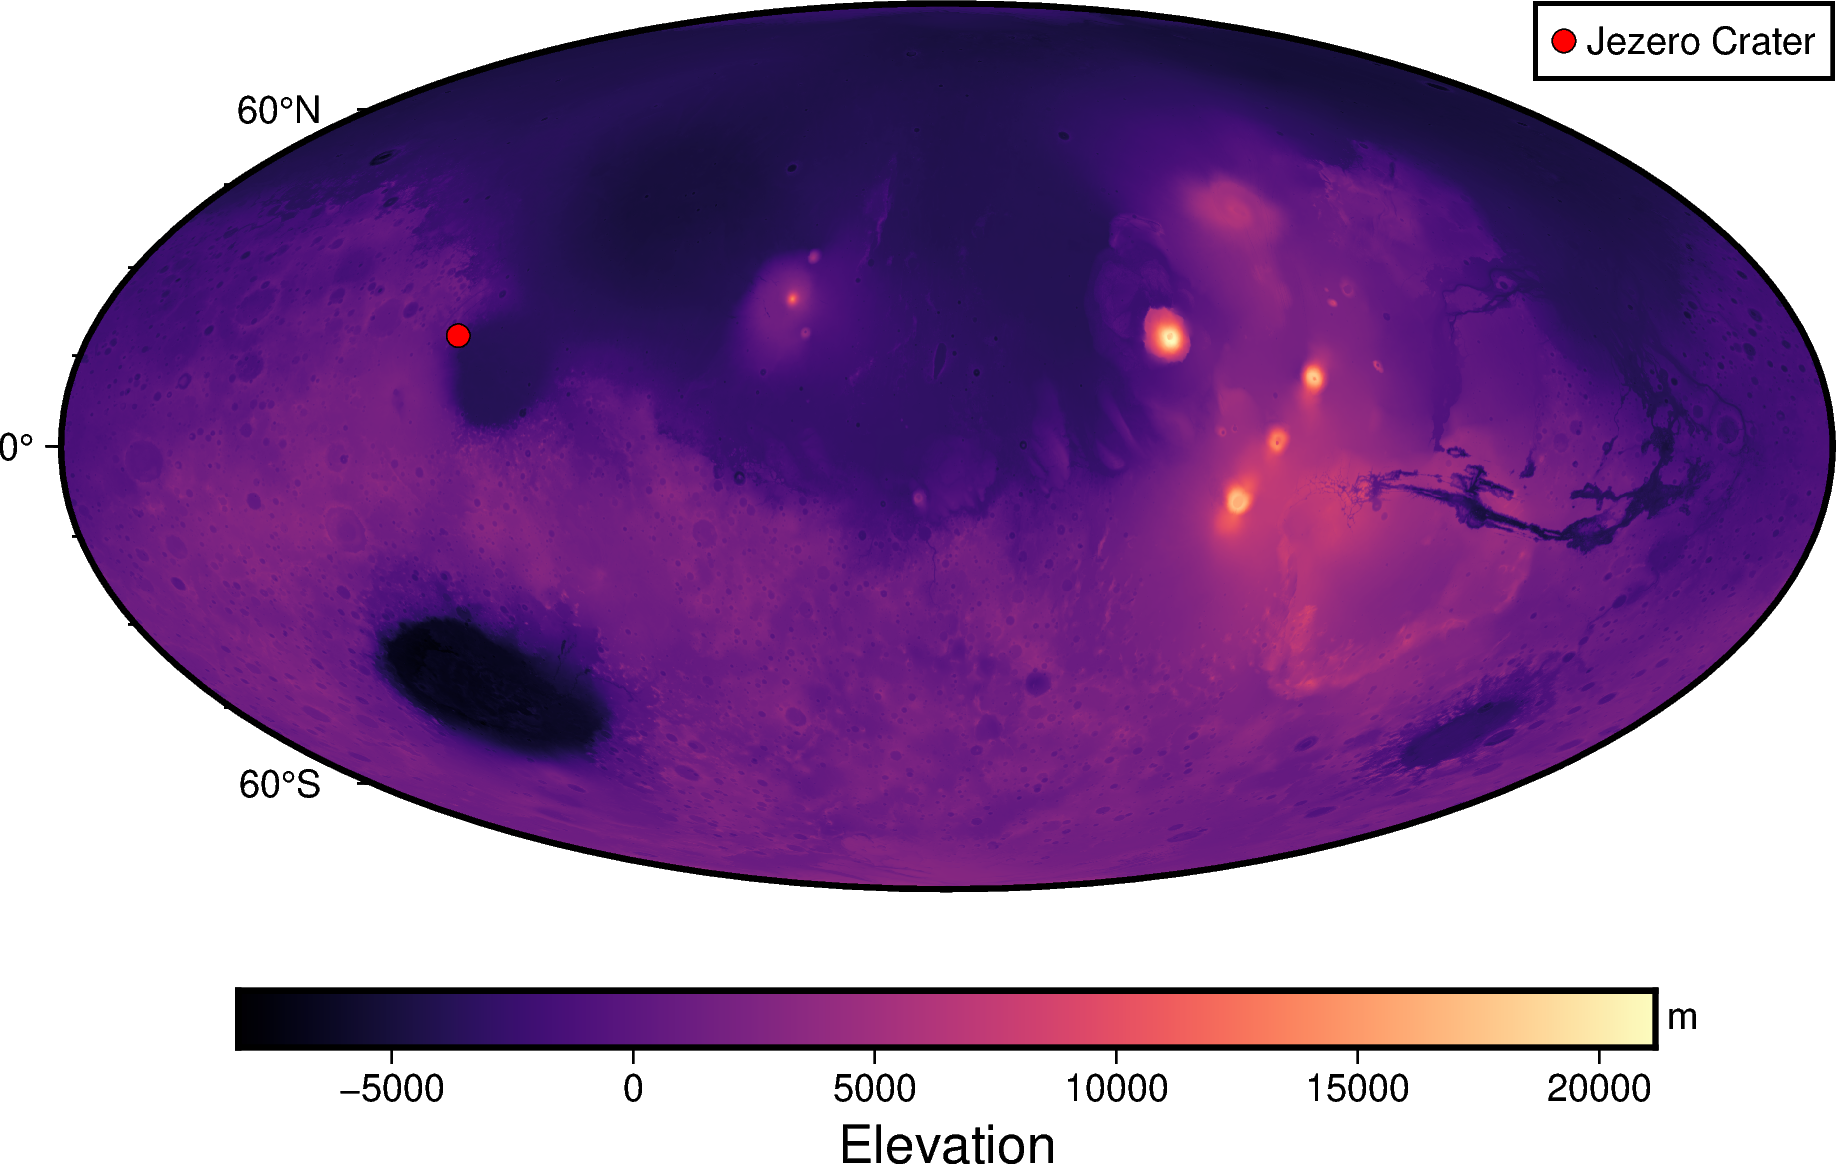

In [5]:
fig = pygmt.Figure()

fig.grdimage(grid=mars_topo,region='g',frame=True,projection='W15c',cmap='magma')
fig.colorbar(frame=['a5000','x+lElevation','y+lm'])

# Plot the position of Jezero Crater
fig.plot(
    x=77.5,
    y=18.4,
    style='c0.2c',  # 'i' for an inverted triangle, '0.5c' for the size (0.5 cm)
    color='red',  # Point color
    pen='black',  # Outline color
    label='Jezero Crater'  # Label for the legend
)

# Define the legend
fig.legend(
    position='JTR+jTR+o0.0c',  # Position: Justify Top Right, plus offset
    box='+gwhite+p1p'  # White background with a black border
)

fig.savefig('mars_paleopole_map.png', dpi=600)
fig.show()

# Specify paleopoles

## Magnetic anomalies

Paleopoles were estimated from magnetic anomalies identified through Mars Global Surveyor data by [Milbury et al. (2012)](https://doi.org/10.1029/2012JE004099). These can be grouped as anomalies that are Noachian vs Hesperian. Table 2 of [Milbury et al. (2012)](https://doi.org/10.1029/2012JE004099) was transcribed to a .csv that is imported below.

In [6]:
M12_poles = pd.read_csv('data/Milbury2012_poles.csv')

M12_poles_H_n = M12_poles[(M12_poles['geologic_designation'] == 'H') & (M12_poles['dipole_moment'] > 0)]
M12_poles_H_r = M12_poles[(M12_poles['geologic_designation'] == 'H') & (M12_poles['dipole_moment'] < 0)]
M12_poles_N_n = M12_poles[(M12_poles['geologic_designation'] == 'N') & (M12_poles['dipole_moment'] > 0)]
M12_poles_N_r = M12_poles[(M12_poles['geologic_designation'] == 'N') & (M12_poles['dipole_moment'] < 0)]

M12_poles_N_n

,anomaly,geologic_designation,source_lon,source_lat,pole_lon,pole_lat,dipole_moment
2,T3,N,100.00,-27.00,76,2,8.700000e+15
7,T8,N,104.75,-10.00,190,24,6.400000e+15
10,T11,N,115.00,-15.00,65,47,1.000000e+16
12,T13,N,119.50,-12.75,76,45,6.700000e+15
15,S3,N,70.00,-7.50,295,52,4.300000e+15
16,S4,N,65.50,-7.00,211,75,1.400000e+16
17,S5,N,58.50,-6.00,303,40,4.200000e+15
18,S6,N,53.00,-5.50,293,44,1.000000e+16
20,S8,N,49.00,-3.00,283,3,1.200000e+16
27,S15,N,52.50,23.00,332,19,6.700000e+14


Plon: 311.9  Plat: 72.2
Number of directions in mean (n): 19
Angular radius of 95% confidence (A_95): 25.6
Precision parameter (k) estimate: 2.7


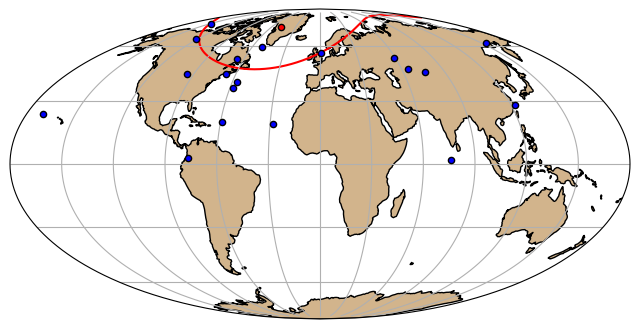

In [18]:
M12_poles_N = M12_poles[(M12_poles['geologic_designation'] == 'N')]
M12_poles_mean = ipmag.fisher_mean(M12_poles_N['pole_lon'].to_list(), 
                                   M12_poles_N['pole_lat'].to_list())
ipmag.print_pole_mean(M12_poles_mean)

map_axis = ipmag.make_mollweide_map()
ipmag.plot_vgp(map_axis, M12_poles_N['pole_lon'].to_list(), M12_poles_N['pole_lat'].to_list(), color='blue')
ipmag.plot_pole(map_axis, M12_poles_mean['dec'], M12_poles_mean['inc'], M12_poles_mean['alpha95'], color='red')
plt.show()

Could explore using a Van Damme type cutoff for outlier detection

## Offset polar deposits

[Kite et al., 2009](http://dx.doi.org/10.1016/j.epsl.2009.01.040) considered the Late Hesperian Dorsa Argentea Formation polar material to be a deposit that could be attributed to be offset from the present-day pole by true polar wander with high confidence.

In [7]:
# Late Hesperian Dorsa Argentea Formation polar materia
# 81.3S 302.1E
# (fixed cap radius)
# change to northern hemisphere pole
K09_lon = 302.1-180
K09_lat = 81.3 

## Remnant rotational figure (pre-Tharsis)

In addition to pole positions estimated from magnetic anomalies, other geophysical and geologic data have been used to both infer and quantify true polar wander. That the massive Tharsis volcanic province (emplaced during the Hesperian Era) with its large positive gravity anomaly is located near the equator has been interpreted to be evidence for large-scale true polar wander ([Melosh, 1980](https://doi.org/10.1016/0019-1035(80)90141-4)). A rotating planetary body is most stable when positive mass anomalies, such as Tharsis, are at the equator (such that the maximum inertial axis is aligned with the rotational axis). Using Martian gravity data [Matsuyama and Manga (2010)](https://doi.org/10.1029/2010JE003686) sought to deconvolve the present-day equilibrium rotational figure from the nonequilibrium contributions arising from Tharsis and a remnant rotational figure from prior to Tharsis emplacement. Their estimate for a remnant rotational figure led to an estimate of ~19º of TPW attributed to the Tharsis load.

[Matsuyama and Manga (2010)](https://doi.org/10.1029/2010JE003686) wrote:

> We calculate the probability density functions for Tharsis' size and location, the paleopole location, and the global average thickness of the elastic lithosphere at the time Tharsis was emplaced. Given the observed degree-3 spherical harmonic gravity coefficients, the expected Tharsis center location is 258.6 ± 4.2°E, 9.8 ± 0.9°N, where the uncertainties represent the 90% confidence interval. Given this Tharsis center location and the observed degree-2 spherical harmonic gravity coefficients, the expected paleopole location prior to the emplacement of Tharsis is 259.5 ± 49.5°E, 71.1−14.4+17.5°N, and the expected elastic lithospheric thickness at the time of loading is 58−32+34 km. Our estimated paleopole colatitude implies 18.9−17.5+14.4° of true polar wander (TPW) driven by the emplacement of Tharsis

This estimate pole position is entered below

In [8]:
MM10_lon = 259.5
MM10_lat = 71.1

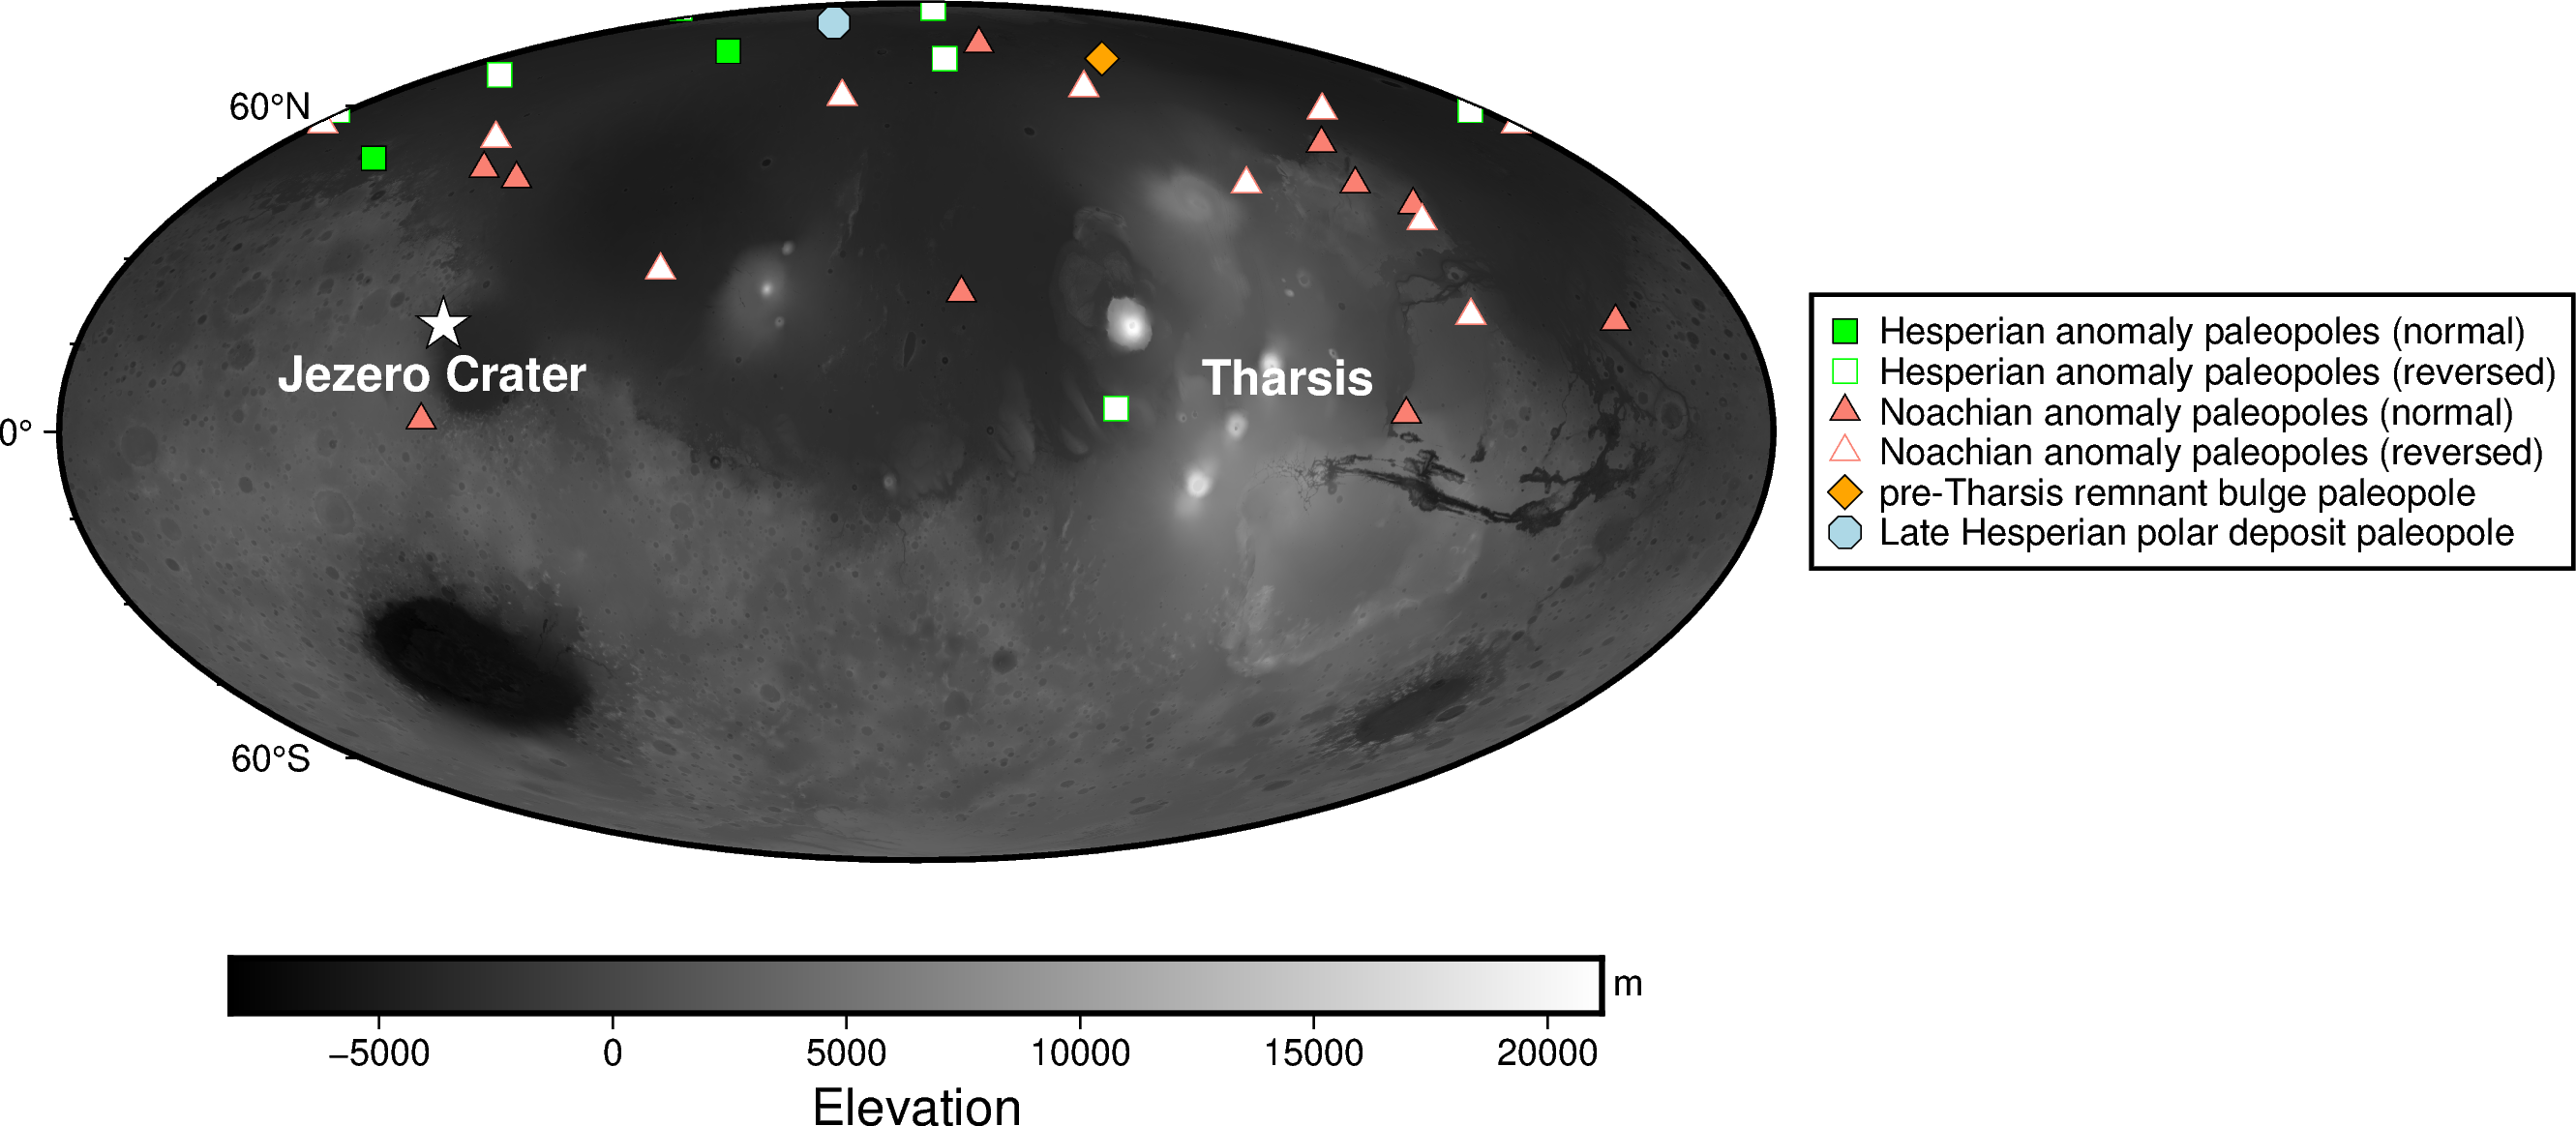

In [25]:
fig = pygmt.Figure()

fig.grdimage(grid=mars_topo, region='g', frame=True, projection='W15c', cmap='gray')
fig.colorbar(frame=['a5000', 'x+lElevation', 'y+lm'])

fig.plot(
    x=77.5,
    y=18.4,
    style='a0.5c',
    color='white',
    pen='black'
)

fig.text(text="Jezero Crater", x=77.5,
            y=10, font='12p,Helvetica-Bold,white')

fig.text(text="Tharsis", x=258.6,
            y=9.3, font='12p,Helvetica-Bold,white')

fig.plot(
    x=M12_poles_H_n['pole_lon'],
    y=M12_poles_H_n['pole_lat'],
    style='s0.3c',  # Square, 0.3 cm size
    color='green',  # Color for 'H' points
    pen='black',
    label='Hesperian anomaly paleopoles (normal)'
)

fig.plot(
    x=M12_poles_H_r['pole_lon'],
    y=M12_poles_H_r['pole_lat'],
    style='s0.3c',  # Square, 0.3 cm size
    color='white',  # Color for 'H' points
    pen='green',
    label='Hesperian anomaly paleopoles (reversed)'
)

fig.plot(
    x=M12_poles_N_n['pole_lon'],
    y=M12_poles_N_n['pole_lat'],
    style='t0.3c',  # Square, 0.3 cm size
    color='salmon',  # Color for 'H' points
    pen='black',
    label='Noachian anomaly paleopoles (normal)'
)

fig.plot(
    x=M12_poles_N_r['pole_lon'],
    y=M12_poles_N_r['pole_lat'],
    style='t0.3c',  # Square, 0.3 cm size
    color='white',  # Color for 'H' points
    pen='salmon',
    label='Noachian anomaly paleopoles (reversed)'
)

fig.plot(
    x=MM10_lon,
    y=MM10_lat,
    style='d0.3c',
    color='orange',
    pen='black',
    label='pre-Tharsis remnant bulge paleopole'
)

fig.plot(
    x=K09_lon,
    y=K09_lat,
    style='g0.3c',
    color='lightblue',
    pen='black',
    label='Late Hesperian polar deposit paleopole'
)


fig.legend(
    position='JMR+jMR+o-7c/0c',
    box='+gwhite+p1p'
)

fig.savefig('mars_paleopole_map.png', dpi=600)
fig.show()


Figure caption:

Estimated Martian paleopole locations shown on an elevation basemap. The ancient position of the Martian spin axis has been interpreted from both geophysical and geologic data. The pole positions shown here come from: inversions to magnetic anomalies ([Milbury et al. (2012)](https://doi.org/10.1029/2012JE004099)), the interpreted position of the pre-Tharsis rotational bulge ([Matsuyama and Manga (2010)](https://doi.org/10.1029/2010JE003686)), and polar deposits offset from the pole ([Kite et al., 2009](http://dx.doi.org/10.1016/j.epsl.2009.01.040)). The paleopoles estimated from inverted magnetic anomalies are both in the southern and northern hemisphere consistent with a reversing dynamo field. For ease of comparison, the antipodes of reversed estimates are plotted so that all poles are in a unified northern hemisphere polarity with differing symbology for normal and reversed paleopoles. These differing pole position estimate make distinct predictions for the magnitude of Martian true polar wander that have the potential to be reflected in the paleomagnetic directions of returned Jezero crater rocks.